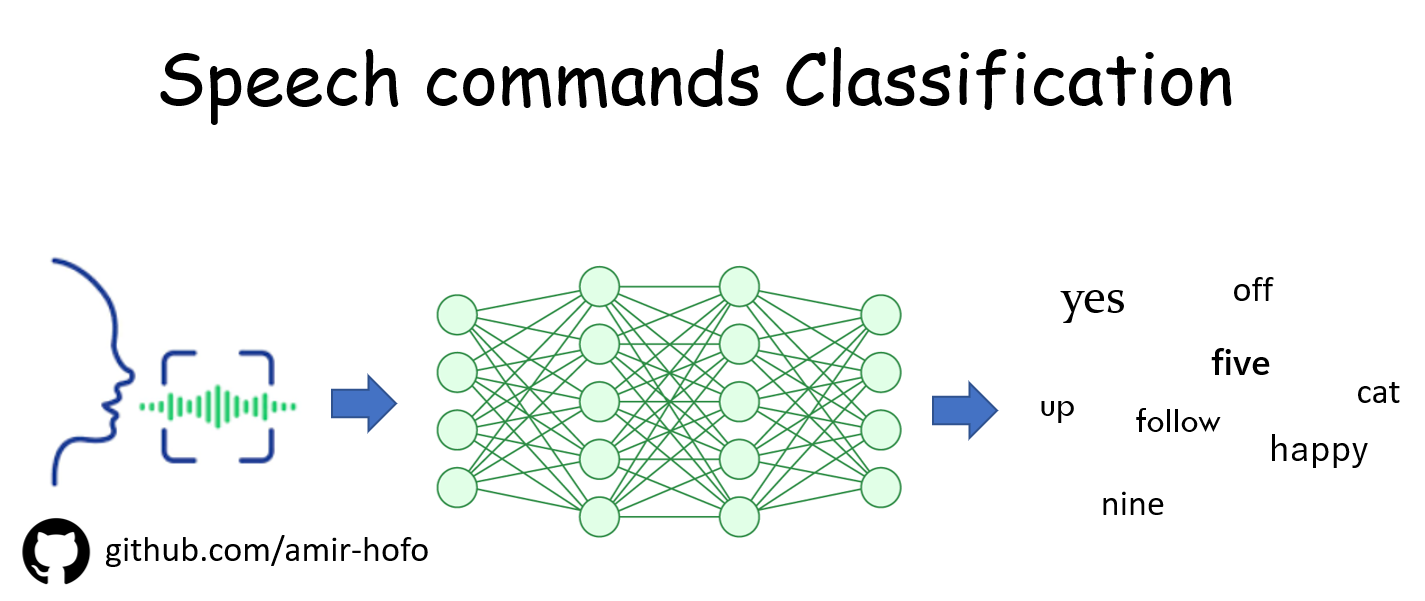

In this notebook, we aim to recognize speech commands using classification. For this purpose, we used the SPEECHCOMMANDS dataset and the deep convolutional model M5. The code is written in Python and designed for the PyTorch platform.

# libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchaudio import datasets
import torchaudio.functional as AF
import matplotlib.pyplot as plt
from torchmetrics import Accuracy

# data

In [2]:
path= r'./'
train_set= datasets.SPEECHCOMMANDS(path, download= True, subset= "training")
valid_set= datasets.SPEECHCOMMANDS(path, download= True, subset= 'validation')
test_set= datasets.SPEECHCOMMANDS(path, download= True, subset= 'testing')
labels= set([mark[2] for mark in valid_set])
label_to_num= {label: num for num, label in enumerate(labels)}
num_class= len(labels)

In [3]:
def collate_fn(batch):
    data= [sample_data[0][0] for sample_data in batch]
    data= pad_sequence(data, batch_first= True)
    data= AF.resample(data, orig_freq= 16000, new_freq= 8000).unsqueeze(1)
    label= torch.tensor([label_to_num[sample_label[2]] for sample_label in batch],
                        dtype= torch.long)
    return data, label

In [4]:
train_loader= DataLoader(train_set, batch_size= 32, 
                         collate_fn= collate_fn, shuffle= True)
valid_loader= DataLoader(valid_set, batch_size= 32, 
                         collate_fn= collate_fn, shuffle= True)
test_loader= DataLoader(test_set, batch_size= 32,
                        collate_fn= collate_fn, shuffle= False)

# model

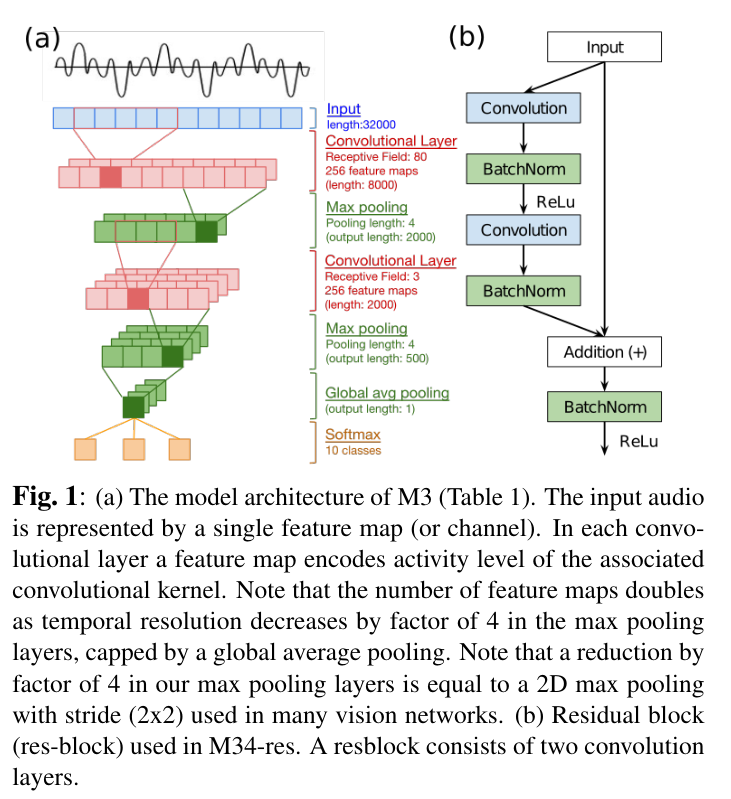

In [5]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return x.squeeze(1)

model= M5()

# train functions

In [6]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [7]:
def train_one_epoch(model, train_loader, loss_fn, optimizer):
    model.train()
    loss_train = AverageMeter()
    acc_train = Accuracy(task="multiclass", num_classes= num_class)
    for i, (inputs, targets) in enumerate(train_loader):
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        optimizer.zero_grad()
        loss_train.update(loss.item())
        acc_train(outputs, targets.int())
    return model, loss_train.avg, acc_train.compute().item()

In [8]:
def evaluate(model, valid_loader, loss_fn):
    valid_error= []
    model.eval()
    with torch.no_grad():
        loss_valid = AverageMeter()
        acc_valid = Accuracy(task="multiclass", num_classes= num_class)
        for i, (inputs, targets) in enumerate(valid_loader):
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss_valid.update(loss.item())
            acc_valid(outputs, targets.int())
    return loss_valid.avg, acc_valid.compute()

# training

epoch14:
train: Loss=0.7266, Accuracy=0.7898
valid: Loss=0.7019, Accuracy=0.797
test: Loss=0.7598, Accuracy=0.7859


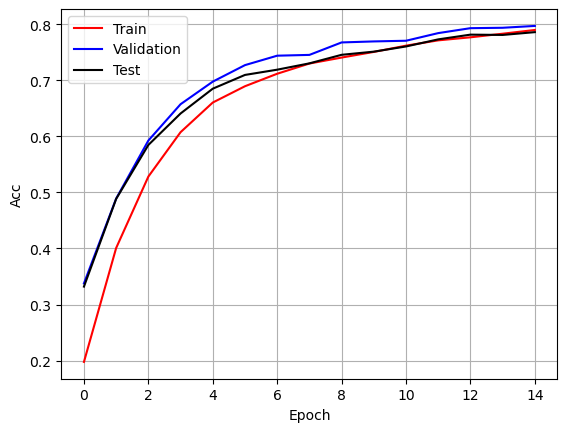

In [9]:
num_epochs= 15
eta= 0.0001
optimizer= optim.Adam(model.parameters(), lr= eta)
loss_fn= nn.CrossEntropyLoss()
loss_train_hist, loss_valid_hist, loss_test_hist, acc_train_hist, \
acc_valid_hist, acc_test_hist = ([] for _ in range(6))
for epoch in range(num_epochs):
    model, loss_train, acc_train= train_one_epoch(model, train_loader, loss_fn, optimizer)
    loss_valid, acc_valid= evaluate(model, valid_loader, loss_fn)
    loss_test, acc_test= evaluate(model, test_loader, loss_fn)
    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)
    loss_test_hist.append(loss_test)
    acc_train_hist.append(acc_train)
    acc_valid_hist.append(acc_valid)
    acc_test_hist.append(acc_test)
print(f'epoch{epoch}:')
print(f'train: Loss={loss_train:.4}, Accuracy={acc_train:.4}')
print(f'valid: Loss={loss_valid:.4}, Accuracy={acc_valid:.4}')
print(f'test: Loss={loss_test:.4}, Accuracy={acc_test:.4}')
plt.plot(range(num_epochs), acc_train_hist, 'r-', label='Train')
plt.plot(range(num_epochs), acc_valid_hist, 'b-', label='Validation')
plt.plot(range(num_epochs), acc_test_hist, 'k-', label='Test')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()